## 환경 설정

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import sys

#경고창이 뜨지 않도록 해주는 것
import warnings
warnings.filterwarnings('ignore')

# notebook을 실행한 브라우저에서 바로 그림을 볼 수 있게 해주는 것
%matplotlib inline 

**주피터 노트북에서 시각화할때, matplotlib가 한글 폰트 지원하지 않아, 깨짐 처리해줘야 함**

In [2]:
import platform                

from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus']= False

if platform.system() == 'Darwin': #맥os 사용자의 경우에
    plt.style.use('seaborn-darkgrid') 
    rc('font', family = 'AppleGothic')
    
elif platform.system() == 'Windows':#윈도우 사용자의 경우에
    path = 'c:/Windows/Fonts/malgun.ttf'
    font_name = font_manager.FontProperties(fname=path).get_name()
    plt.style.use('seaborn-darkgrid') # https://python-graph-gallery.com/199-matplotlib-style-sheets/
    rc('font', family=font_name)

In [3]:
# 데이터 불러오기 
df = pd.read_csv('./NYC_taxi.csv')

# 여기 아래 부분 꼭 실행시켜주세요! 
df['pickup_hour'] = pd.to_datetime(df['pickup_hour'])
df['zip_code'] = df['zip_code'].astype(str) 

# 데이터 전처리

### 모델링을 위한 기본 전처리
  - `기본 정보 확인 (결측치 및 이상치 처리)`
      - df.info()
      - df.describe()
      - 간단한 시각화 
  - `시간 관련 전처리 (새로운 열 생성)` 
      - DATETIME에서 MONTH, HOUR, WEEKDAY 등 추출
  - `Categorical 데이터 전처리`
      - One Hot Encoding
      - Label Encoding
  - `Train / Test Split`
    - NY taxi data에서 주의점 

### 기본 정보 확인 (결측치 및 이상치 처리) 
  - df.info()
  - df.describe()
  - 간단한 시각화 



---


EDA 과정에서 기본적으로 다 확인하셨죠? ㅎㅎ 
EDA 결과 중 모델링에 적용하기로한 부분이 있다면 반영해주세요~!

In [4]:
# 결측치 없고, 총 87020개의 row
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87020 entries, 0 to 87019
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   zip_code     87020 non-null  object        
 1   pickup_hour  87020 non-null  datetime64[ns]
 2   month        87020 non-null  int64         
 3   day          87020 non-null  int64         
 4   weekday      87020 non-null  int64         
 5   hour         87020 non-null  int64         
 6   is_weekend   87020 non-null  int64         
 7   cnt          87020 non-null  int64         
dtypes: datetime64[ns](1), int64(6), object(1)
memory usage: 5.3+ MB


### 1. Target 값인 'cnt'의 분포 확인 및 조정

In [5]:
# 'cnt'의 skewness가 매우 심함을 알 수 있음
from scipy.stats import skew, kurtosis
df['cnt'].describe()

count    87020.000000
mean       141.603080
std        306.902683
min          1.000000
25%          2.000000
50%         12.000000
75%         80.000000
max       2657.000000
Name: cnt, dtype: float64

In [6]:
# 수요예측의 유의미성을 위해 수요가 과다하게 적은 지역의 데이터는 학습/예측에서 제외
zip_df = df.groupby(by = ['zip_code'])['cnt'].sum().reset_index()
print('총 구역 수 :', zip_df.shape[0])
print('한달간 총 pickup이 100건 이하인 구역 수:',zip_df[zip_df['cnt'] < 100].shape[0])

총 구역 수 : 374
한달간 총 pickup이 100건 이하인 구역 수: 216


In [7]:
drop_zip = zip_df[zip_df['cnt'] < 100]['zip_code'].tolist()
df = df[~df.zip_code.isin(drop_zip)]
df.shape

(84217, 8)

In [8]:
# 왜도와 첨도 확인
print('Skewness :', round(skew(df['cnt']),4))
print('Kurtosis:', round(kurtosis(df['cnt']),4))

Skewness : 2.9365
Kurtosis: 9.5327


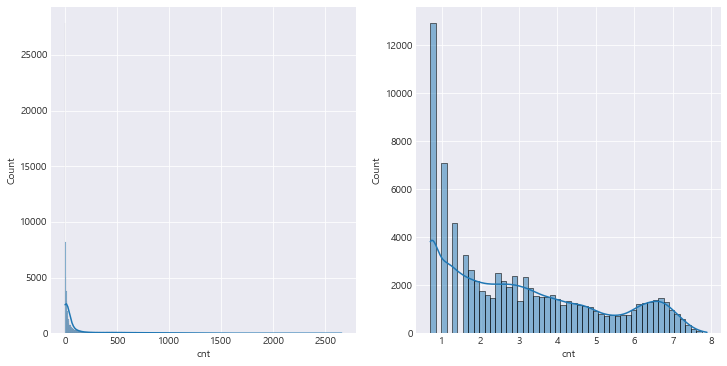

In [9]:
# target 시각화 (right-skewed distribution 확인)
fig, ax = plt.subplots(1, 2, figsize = (12,6))
sns.histplot(x = df['cnt'], ax=ax[0], kde=True)
sns.histplot(x = np.log1p(df['cnt']), ax=ax[1], kde=True)
plt.show()

In [10]:
# 로그 변환 시 왜도와 첨도가 많이 개선됨을 확인
print('Skewness :', round(skew(np.log1p(df['cnt'])),4))
print('Kurtosis:', round(kurtosis(np.log1p(df['cnt'])),4))

Skewness : 0.574
Kurtosis: -0.8481


### 2. 이상치에 해당하는 데이터 및 불필요한 feature 제거

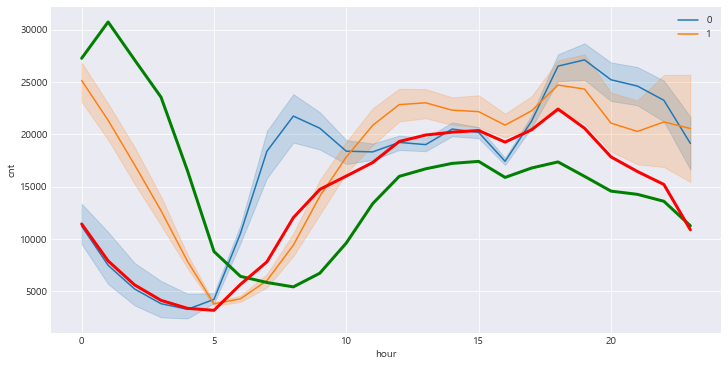

In [11]:
# 1일과 19일 공휴일의 시간별 수요 패턴을 주중, 주말 패턴과 비교
# 예측 데이터셋에 공휴일이 없고, 공휴일 간 패턴이 매우 특이하므로 해당 데이터도 우선 예측 효율성을 위해 제거
cnt_df = df.groupby(by = ['day', 'hour', 'is_weekend'])['cnt'].sum().reset_index()
cnt_df = cnt_df.drop(index = cnt_df[(cnt_df['day'] == 26)|(cnt_df['day'] == 27)].index)
plt.figure(figsize = (12,6))
sns.lineplot(data = cnt_df, x = 'hour', y ='cnt', hue='is_weekend')
sns.lineplot(data = cnt_df[cnt_df['day']==1], x = 'hour', y='cnt', color='g', linewidth=3)
sns.lineplot(data = cnt_df[cnt_df['day']==19], x = 'hour', y='cnt', color='r', linewidth=3)
plt.show()

### 3. 인코딩까지 포함한 전처리 함수 정의
- generate_ohe_df() : 이후 linear regression에 활용하기 위해 one-hot encoding
- generate_le_df() : 이후 트리계열 알고리즘에 활용하기 위해 label encoding (속도 개선을 위해)

In [12]:
def generate_ohe_df(df) :
    df_copy = df.copy()
    # target log transformation
    df_copy['cnt'] = np.log1p(df_copy['cnt'])
    # 이상치 제거
    outlier_index = df_copy[(df_copy['day'] == 1)|(df_copy['day'] == 19)|
                       (df_copy['day'] == 26)|(df_copy['day'] == 27)].index
    df_copy.drop(index = outlier_index, inplace = True)
    # 불필요한 feature 제거
    df_copy.drop(['month', 'is_weekend', 'day'], axis = 1, inplace=True)
    # feature 모두 one-hot encoding
    df_copy = pd.get_dummies(df_copy, columns = ['zip_code', 'weekday', 'hour'])
    return df_copy

In [13]:
from sklearn.preprocessing import LabelEncoder
def generate_le_df(df) :
    df_copy = df.copy()
    # target log transformation
    df_copy['cnt'] = np.log1p(df_copy['cnt'])
    # 이상치 제거
    outlier_index = df_copy[(df_copy['day'] == 1)|(df_copy['day'] == 19)|
                       (df_copy['day'] == 26)|(df_copy['day'] == 27)].index
    df_copy.drop(index = outlier_index, inplace = True)
    # 불필요한 feature 제거
    df_copy.drop(['month', 'is_weekend', 'day'], axis = 1, inplace=True)
    # feature 모두 one-hot encoding
    le = LabelEncoder()
    le.fit(df_copy['zip_code'])
    df_copy['zip_code_le'] = le.transform(df_copy['zip_code'])
    df_copy.drop('zip_code', axis=1, inplace=True)
    return df_copy

### Train and Test Split
- 시계열 데이터는 Random Sampling을 하면 안됨
- Train엔 과거 데이터, Test엔 (과거 대비) 미래 데이터가 있어야 함
    - 만약 Train에 미래 데이터가 있다면? 미래를 보고 과거를 예측한 꼴
    - 실제로 사용할 땐 과거 데이터 기반으로 미래 데이터를 예측

In [14]:
def split_train_and_test(df, date):
    #date : 기준점 날짜
    train_df = df[df['pickup_hour'] < date]
    test_df = df[df['pickup_hour'] >= date]
    return train_df, test_df

In [15]:
le_df = generate_le_df(df)
train_df, test_df = split_train_and_test(le_df, '2015-01-24')

In [16]:
del train_df['pickup_hour']
del test_df['pickup_hour']

In [17]:
x_train = train_df.drop('cnt', axis=1)
y_train = train_df['cnt']

x_test = test_df.drop('cnt', axis=1)
y_test = test_df['cnt'] 

In [18]:
print("Train dataset 크기:", x_train.shape)
print("Test dataset 크기:", x_test.shape)

Train dataset 크기: (57203, 3)
Test dataset 크기: (16677, 3)


## 모델링
: Tree 계열 RandomForest, XGBoost와 LinearRegression 활용

In [19]:
import random
random_seed = 777

In [20]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, make_scorer
from sklearn.model_selection import GridSearchCV, KFold

#### 함수 정의
- regression_evaluation() : 모델을 통해 예측을 진행하고 RMSE, MAPE, r2_score 평가지표를 반환
- get_best_params() : 입력한 파라미터들에 대해 GridSearchCV를 진행하고 최적 파라미터와 그 점수를 출력, 최적 학습기를 반환 
- cross_validation() : KFOLD 교차검증을 진행하고 검증할 때 regression_evaluation() 함수를 호출해 평가지표를 Dataframe으로 만들어 반환

In [21]:
# 회귀 성능평가지표 반환 (RMSE, MAPE, R2_SCORE)
def regression_evaluation(model, x_test, y_test) :
    preds = model.predict(x_test)
    
    y_test = np.expm1(y_test)
    preds = np.expm1(preds)
    
    rmse = round(np.sqrt(mean_squared_error(y_test, preds)),4)
    mape = round(mean_absolute_percentage_error(y_test, preds),4)
    r2 = round(r2_score(y_test, preds),4)

    return rmse, mape, r2

In [22]:
# GridSearchCV를 통한 하이퍼 파라미터 튜닝
def get_best_params(model, params):
    grid_model = GridSearchCV(model, param_grid=params, 
                              scoring = 'neg_mean_squared_error', cv=3)
    grid_model.fit(x_train, y_train)
    rmse = np.sqrt(-1 * grid_model.best_score_)
    print('{0} 최적 params : {1}'.format(model.__class__.__name__, grid_model.best_params_))
    return grid_model.best_estimator_

In [23]:
# KFOLD 교차 검증을 통해 각 검증의 평가지표 값 출력
def cross_validation(model, features, label, k=5) :
    n_iter = 0
    kfold = KFold(n_splits=k)
    eval_list = []
    # KFold객체의 split( ) 호출하면 폴드 별 학습용, 검증용 테스트의 로우 인덱스를 array로 반환
    for train_index, test_index in kfold.split(features):
        X_train, X_test = features.iloc[train_index], features.iloc[test_index]
        y_train, y_test = label.iloc[train_index], label.iloc[test_index]
        # 학습 및 예측 
        model.fit(X_train , y_train)
        rmse, mape, r2 = regression_evaluation(model, X_test, y_test)
        eval_list.append((rmse, mape, r2))
        n_iter += 1
        
    eval_df = pd.DataFrame(eval_list, columns = ['RMSE', 'MAPE', 'R2'])
    return eval_df

### 1. RandomForestRegressor

In [24]:
# 랜덤포레스트 base model 생성
from sklearn.ensemble import RandomForestRegressor
rf_reg = RandomForestRegressor(n_estimators=100, random_state=random_seed) 

In [25]:
# base model로 kfold 교차 검증 : 
cross_validation(rf_reg, x_train, y_train, k=5)

,RMSE,MAPE,R2
0,91.2875,0.5351,0.8781
1,43.5670,0.3516,0.9818
2,61.6500,0.3539,0.9655
3,53.5954,0.3432,0.9755
4,44.3780,0.3520,0.9817


In [26]:
params = {
    'n_estimators': [100, 200],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [2, 5, 8],
    'max_depth' : [30, 40, 50]
}
best_rf_reg = get_best_params(rf_reg, params = params)

RandomForestRegressor 최적 params : {'max_depth': 30, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 200}


In [27]:
best_rf_reg.fit(x_train, y_train)
rmse, mape, r2 = regression_evaluation(best_rf_reg, x_test, y_test)
print('RMSE : {0} MAPE : {1} R2 : {2}'.format(rmse, mape, r2))

RMSE : 52.6536 MAPE : 0.3552 R2 : 0.9744


### 2. XGBRegressor

In [28]:
# XGBRegressor base model 생성
from xgboost import XGBRegressor
xgb_reg = XGBRegressor(n_estimators=1000, learning_rate=0.1, random_state = random_seed)

In [29]:
# base model로 kfold 교차 검증
cross_validation(xgb_reg, x_train, y_train, k=5)

,RMSE,MAPE,R2
0,91.4896,0.5037,0.8775
1,45.6936,0.3286,0.9799
2,65.1396,0.3376,0.9615
3,55.7480,0.3303,0.9735
4,46.7384,0.3299,0.9797


In [30]:
params = {
    'n_estimators' : [1000],
    'verbosity' : [0],
    'learning_rate' : [0.1, 0.2, 0.3],
    'subsample' : [0.75, 1],
    'max_depth' : [5, 7, 9]    
}

best_xgb_reg = get_best_params(xgb_reg, params)

XGBRegressor 최적 params : {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 1000, 'subsample': 1, 'verbosity': 0}


In [31]:
best_xgb_reg.fit(x_train, y_train)
rmse, mape, r2 = regression_evaluation(best_xgb_reg, x_test, y_test)
print('RMSE : {0} MAPE : {1} R2 : {2}'.format(rmse, mape, r2))

RMSE : 54.0619 MAPE : 0.3579 R2 : 0.973


### 3. LinearRegression

In [32]:
ohe_df = generate_ohe_df(df)
train_df, test_df = split_train_and_test(ohe_df, '2015-01-24')

In [33]:
del train_df['pickup_hour']
del test_df['pickup_hour']

In [34]:
x_train = train_df.drop('cnt', axis=1)
y_train = train_df['cnt'] 

x_test = test_df.drop('cnt', axis=1)
y_test = test_df['cnt'] 

In [35]:
from sklearn.linear_model import LinearRegression
lr_reg = LinearRegression()

In [36]:
cross_validation(lr_reg, x_train, y_train, k=5)

,RMSE,MAPE,R2
0,122.6269,1.0316,0.7800
1,147.6689,0.8360,0.7905
2,159.4988,0.8467,0.7693
3,166.2850,0.7953,0.7639
4,145.4414,0.8994,0.8036


In [37]:
lr_reg.fit(x_train, y_train)
rmse, mape, r2 = regression_evaluation(lr_reg, x_test, y_test)
print('RMSE : {0} MAPE : {1} R2 : {2}'.format(rmse, mape, r2))

RMSE : 155.3914 MAPE : 0.863 R2 : 0.7767
